In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
import jax.numpy as jnp
import numpy as np

import optax

# from data.data import Mcycle, Step, Olympic, Heinonen4, Tolvanen14

from tinygp import GaussianProcess, kernels
import matplotlib.pyplot as plt

from gpax import ExactGP, HeteroscedasticNoise, GibbsKernel, SparseGP
from gpax.utils import constrain, randomize, unconstrain

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import lab.jax as B
from jax.config import config
config.update("jax_enable_x64", True)

# from jax.config import config
# config.update("jax_debug_nans", True)

imported sthenogpax version


In [43]:
####################################
method = "gibbs_gp"

# data = Olympic()()
seed = 0
n_restarts = 10
num_epochs = 1000
lr = 0.05
optimizer = optax.adam(lr)
flex_scale = True
flex_variance = True
add_prior = True
sparse_gp = False
B.epsilon = 1e-3

lengthscale_prior = tfd.TransformedDistribution(tfd.Gamma(5.0, 1.0), tfb.Log())
variance_prior = tfd.TransformedDistribution(tfd.Gamma(0.5, 1.0), tfb.Log())

# name = f"{method}/{data.__class__.__name__}_seed_{seed}_epochs_{num_epochs}_lr_{lr}_n_restarts_{n_restarts}"
####################################

In [44]:
# for i in range(10):
#     sample = lengthscale_prior.sample(seed=jax.random.PRNGKey(i))
#     print(lengthscale_prior.log_prob(sample))

In [45]:
def loss_fn(params, X, y, X_inducing):
    if flex_variance:
        params["kernel"]["variance_gp"]["noise"]["variance"] = jax.lax.stop_gradient(
            params["kernel"]["variance_gp"]["noise"]["variance"]
        )
    if flex_scale:
        params["kernel"]["scale_gp"]["noise"]["variance"] = jax.lax.stop_gradient(
            params["kernel"]["scale_gp"]["noise"]["variance"]
        )
    params["noise"]["noise_gp"]["noise"]["variance"] = jax.lax.stop_gradient(
        params["noise"]["noise_gp"]["noise"]["variance"]
    )
    if sparse_gp:
        kernel = GibbsKernel(flex_scale=flex_scale, flex_variance=flex_variance)
        gp = SparseGP(
            kernel=kernel, noise=HeteroscedasticNoise(use_kernel_inducing=False)
        )
    else:
        kernel = GibbsKernel(X_inducing=X_inducing, flex_scale=flex_scale, flex_variance=flex_variance)
        gp = ExactGP(kernel=kernel, noise=HeteroscedasticNoise())
    gp.initialise_params(jax.random.PRNGKey(0), X=X, X_inducing=X_inducing)
    bijectors = gp.get_bijectors()
    loss = 0.0
    if add_prior:
        prior = tfd.Normal(0.0, 1.0)
        if flex_scale:
            loss -= prior.log_prob(params["kernel"]["inducing_std_scale"]).sum()
        if flex_variance:
            loss -= prior.log_prob(params["kernel"]["inducing_std_variance"]).sum()
        loss -= prior.log_prob(params["noise"]["inducing_std_noise"]).sum()

        prior = variance_prior
        if flex_scale:
            var_prior_scale_gp = prior.log_prob(
                params["kernel"]["scale_gp"]["kernel"]["variance"]
            ).sum()
#             print("var_prior_scale_gp", var_prior_scale_gp)
            loss -= var_prior_scale_gp
        if flex_variance:
            var_prior_var_gp = prior.log_prob(
                params["kernel"]["variance_gp"]["kernel"]["variance"]
            ).sum()
#             print("var_prior_var_gp", var_prior_var_gp)
            loss -= var_prior_var_gp
        var_prior_noise_gp = prior.log_prob(params["noise"]["noise_gp"]["kernel"]["variance"]).sum()
#         print("var_prior_noise_gp", var_prior_noise_gp)
        loss -= var_prior_noise_gp

        prior = lengthscale_prior
        if flex_scale:
            scale_prior_scale_gp = prior.log_prob(
                params["kernel"]["scale_gp"]["kernel"]["lengthscale"]
            ).sum()
#             print("scale_prior_scale_gp", scale_prior_scale_gp)
            loss -= scale_prior_scale_gp
        if flex_variance:
            scale_prior_var_gp = prior.log_prob(
                params["kernel"]["variance_gp"]["kernel"]["lengthscale"]
            ).sum()
#             print("scale_prior_var_gp", scale_prior_var_gp)
            loss -= scale_prior_var_gp
        
        scale_prior_noise_gp = prior.log_prob(params["noise"]["noise_gp"]["kernel"]["lengthscale"]).sum()
#         print("scale_prior_noise_gp", scale_prior_noise_gp)
        loss -= scale_prior_noise_gp
    
    ##########################################
    params = constrain(params, bijectors)
    loss -= gp.log_probability(params, X, y)
    ##########################################
    
    return loss


def get_gp(X_inducing):
    if sparse_gp:
        kernel = GibbsKernel(flex_scale=flex_scale, flex_variance=flex_variance)
        gp = SparseGP(
            kernel=kernel, noise=HeteroscedasticNoise(use_kernel_inducing=False)
        )
    else:
        kernel = GibbsKernel(X_inducing=X_inducing, flex_scale=flex_scale, flex_variance=flex_variance)
        gp = ExactGP(kernel=kernel, noise=HeteroscedasticNoise())
    return gp


def initialize_params(key, X, X_inducing):
    gp = get_gp(X_inducing)
    params = gp.initialise_params(key, X=X, X_inducing=X_inducing)
    params = unconstrain(params, gp.get_bijectors())
    params = randomize(params, key)

    if sparse_gp:
        params["X_inducing"] = X_inducing
    else:
        params["kernel"]["X_inducing"] = X_inducing
    prior = variance_prior
    if flex_scale:
        key = jax.random.split(key, 1)[0]
        params["kernel"]["scale_gp"]["kernel"]["variance"] = prior.sample(
            seed=key,
            sample_shape=params["kernel"]["scale_gp"]["kernel"]["variance"].shape,
        )
    if flex_variance:
        key = jax.random.split(key, 1)[0]
        params["kernel"]["variance_gp"]["kernel"]["variance"] = prior.sample(
            seed=key,
            sample_shape=params["kernel"]["variance_gp"]["kernel"]["variance"].shape,
        )
    params["noise"]["noise_gp"]["kernel"]["variance"] = prior.sample(
        seed=key, sample_shape=params["noise"]["noise_gp"]["kernel"]["variance"].shape
    )

    prior = lengthscale_prior
    if flex_scale:
        key = jax.random.split(key, 1)[0]
        params["kernel"]["scale_gp"]["kernel"]["lengthscale"] = prior.sample(
            seed=key,
            sample_shape=params["kernel"]["scale_gp"]["kernel"]["lengthscale"].shape,
        )
    if flex_variance:
        key = jax.random.split(key, 1)[0]
        params["kernel"]["variance_gp"]["kernel"]["lengthscale"] = prior.sample(
            seed=key,
            sample_shape=params["kernel"]["variance_gp"]["kernel"]["lengthscale"].shape,
        )
    params["noise"]["noise_gp"]["kernel"]["lengthscale"] = prior.sample(
        seed=key,
        sample_shape=params["noise"]["noise_gp"]["kernel"]["lengthscale"].shape,
    )

    if flex_scale:
        params["kernel"]["scale_gp"]["noise"]["variance"] = jnp.log(B.epsilon).repeat(
            X.shape[1]
        )
    if flex_variance:
        params["kernel"]["variance_gp"]["noise"]["variance"] = jnp.log(B.epsilon).repeat(X.shape[1])
    params["noise"]["noise_gp"]["noise"]["variance"] = jnp.log(B.epsilon).repeat(
        X.shape[1]
    )

    return params


def training_fn(key, X, y, X_inducing):
    params = initialize_params(key, X, X_inducing)
    state = optimizer.init(params)
    loss_fn_in = jax.tree_util.Partial(loss_fn, X=X, y=y, X_inducing=X_inducing)

    # dry run
#     loss_fn_in(params)
    
    @jax.jit
    def step(params_and_state, aux):
        params, state = params_and_state
        loss, grads = jax.value_and_grad(loss_fn_in)(params)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state), (params, loss)

    (params, state), (params_history, loss_history) = jax.lax.scan(
        f=step, init=(params, state), xs=None, length=num_epochs
    )
    return {
        "params": params,
        "params_history": params_history,
        "loss_history": loss_history,
    }


def train_and_predict_fold(i):
    key = jax.random.PRNGKey(seed)
    keys = jax.random.split(key, num=n_restarts)
    training_fn_in = jax.tree_util.Partial(
        training_fn,
        X=data["folds"][i]["X_train"],
        y=data["folds"][i]["y_train"],
        X_inducing=data["folds"][i]["X_inducing"],
    )
    result = jax.vmap(training_fn_in)(keys)

    min_idx = jnp.nanargmin(result["loss_history"], axis=1)
    print("min_indices", min_idx)
    losses = jax.vmap(lambda result, idx: result[idx])(result["loss_history"], min_idx)
    print("individual restart losses", losses)
    best_restart = jnp.nanargmin(losses)
    best_result = jax.tree_util.tree_map(lambda x: x[best_restart], result)
    best_params = jax.tree_util.tree_map(
        lambda x: x[min_idx[best_restart] - 1], best_result["params_history"]
    )

    #     best_restart = jnp.argmin(result["loss_history"][:, -1])
    #     best_result = jax.tree_util.tree_map(lambda x: x[best_restart], result)

    gp = get_gp(data["folds"][i]["X_inducing"])
    gp.initialise_params(
        jax.random.PRNGKey(0),
        X=data["folds"][i]["X_train"],
        X_inducing=data["folds"][i]["X_inducing"],
    )
    bijectors = gp.get_bijectors()
    cons_params = constrain(best_params, bijectors)

    pred_mean, pred_covar = gp.predict(
        cons_params,
        data["folds"][i]["X_train"],
        data["folds"][i]["y_train"],
        data["folds"][i]["X_test"],
    )

    pred_mean_grid, pred_covar_grid = gp.predict(
        cons_params,
        data["folds"][i]["X_train"],
        data["folds"][i]["y_train"],
        data["X_grid"],
    )

    pred_scale = gp.kernel.predict_scale(cons_params, data["X_grid"])
    pred_var = gp.kernel.predict_var(cons_params, data["X_grid"])
    pred_noise = gp.noise(cons_params, data["X_grid"])

    #     pred_covar = pred_covar + 1e-3 * jnp.eye(pred_covar.shape[0])
    #     print(jnp.diag(pred_covar)**0.5)
    nlpd = -tfd.MultivariateNormalFullCovariance(
        pred_mean.ravel(), pred_covar
    ).log_prob(data["folds"][i]["y_test"].ravel())
    msll = (
        -tfd.Normal(pred_mean.ravel(), jnp.diag(pred_covar) ** 0.5)
        .log_prob(data["folds"][i]["y_test"].ravel())
        .mean()
    )
    rmse = jnp.sqrt(
        jnp.mean((pred_mean.ravel() - data["folds"][i]["y_test"].ravel()) ** 2)
    )

    print(f"Fold {i}: MSLL = {msll}, RMSE = {rmse}, NLPD = {nlpd}")
    return {
        "nlpd": nlpd,
        "msll": msll,
        "rmse": rmse,
        "pred_mean": pred_mean,
        "pred_covar": pred_covar,
        "pred_mean_grid": pred_mean_grid,
        "pred_covar_grid": pred_covar_grid,
        "pred_scale": pred_scale,
        "pred_var": pred_var,
        "pred_noise": pred_noise,
        "best_result": best_result,
        "best_params": best_params,
        "result": result,
    }

In [46]:
# restart_i = 0
# epoch_i = 999
# jax.tree_util.tree_map(lambda x:x[restart_i][epoch_i], result[0]['result']['params_history'])

### Synthetic dataset

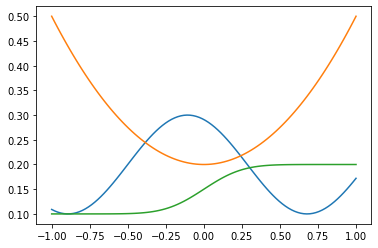

In [48]:
x = jnp.linspace(-1, 1, 100)
lengthscale_trend = lambda x: (0.1 * jnp.sin(4 * (x+0.5))) + 0.2
variance_trend =  lambda x: (0.3 * x**2) + 0.2
noise_var_trend = lambda x: 0.1 * jax.scipy.stats.norm.cdf(5 * x) + 0.1

plt.plot(x, lengthscale_trend(x))
plt.plot(x, variance_trend(x))
plt.plot(x, noise_var_trend(x));

def kernel_fn(x1, ls1, var1, x2, ls2, var2):
    l_sqr_avg = (ls1**2 + ls2**2)/2
    prefix = jnp.sqrt(ls1*ls2/l_sqr_avg)
    exp_part = jnp.exp(-0.5 * ((x1 - x2)**2)/l_sqr_avg)
    return var1 * var2 * prefix * exp_part

kernel_fn = jax.vmap(kernel_fn, in_axes=(None, None, None, 0, 0, 0))
kernel_fn = jax.vmap(kernel_fn, in_axes=(0, 0, 0, None, None, None))

covariance = kernel_fn(x, lengthscale_trend(x), variance_trend(x), x, lengthscale_trend(x), variance_trend(x))

rows, columns = jnp.diag_indices_from(covariance)
covariance = covariance.at[rows, columns].set(covariance[rows, columns]+noise_var_trend(x))

y = jnp.linalg.cholesky(covariance) @ jax.random.normal(jax.random.PRNGKey(123321), shape=(100,))
x = x.reshape(-1,1)

# plt.figure()
# plt.scatter(x, y);

## Gap Step data

(100, 1) (100,)


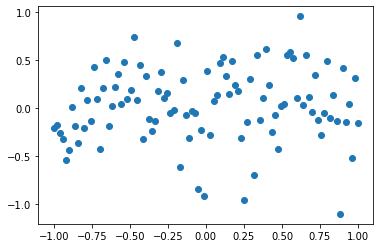

In [49]:
# end_points = [(-1.25, -0.74), (-0.76, -0.2), (0.5, 0.74), (0.76, 1.5)]
# n = 100
# x = jnp.concatenate([jnp.linspace(start, end, int(n*abs((end-start)))) for start, end in end_points]).reshape(-1, 1)
# y = jnp.concatenate([jnp.ones(int(n*abs((end-start))))*jnp.sign((i%2) - 0.5) for i, (start, end) in enumerate(end_points)])
# y += jax.random.normal(jax.random.PRNGKey(0), y.shape)*0.001
# df = Tolvanen14()
# noise_var_trend = df.noise_var
# variance_trend = df.var
# x, y = df(data_seed=0)

print(x.shape, y.shape)
plt.scatter(x, y);

(10, 1)


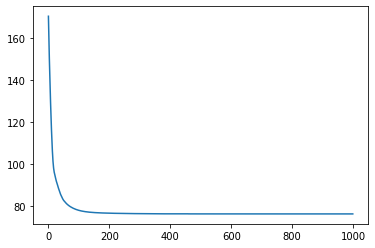

In [53]:
X_inducing = x[::10]
print(X_inducing.shape)

result = training_fn(jax.random.PRNGKey(3), x, y, X_inducing)

plt.plot(result["loss_history"]);

In [54]:
params = jax.tree_util.tree_map(lambda x:x[-1], result["params_history"])
x_test = jnp.linspace(-1.5, 2.0, 1000).reshape(-1, 1)
gp = get_gp(X_inducing)
gp.initialise_params(
    jax.random.PRNGKey(1), X=x, X_inducing=X_inducing
)
bijectors = gp.get_bijectors()
cons_params = constrain(params, bijectors)

pred_mean, pred_covar = gp.predict(cons_params, x, y, x_test)

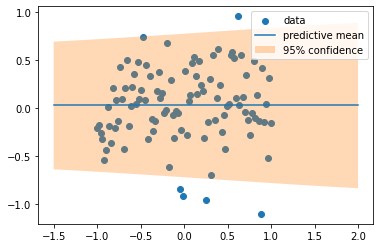

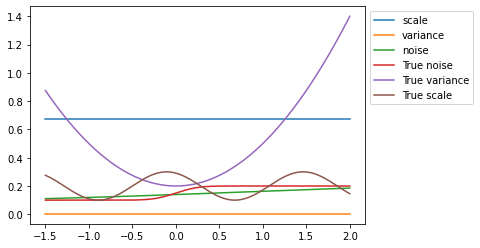

In [55]:
std2 = jnp.diag(pred_covar)**0.5

plt.scatter(x, y, label='data')
plt.plot(x_test, pred_mean, label='predictive mean');
plt.fill_between(x_test.ravel(), pred_mean.ravel()-2*std2, pred_mean.ravel()+2*std2, label='95% confidence', alpha=0.3);
# plt.vlines(cons_params["kernel"]["X_inducing"], *plt.ylim())
plt.legend(bbox_to_anchor=(1,1));
plt.figure();
plt.plot(x_test, gp.kernel.predict_scale(cons_params, x_test).ravel(), label='scale');
plt.plot(x_test, gp.kernel.predict_var(cons_params, x_test).ravel(), label='variance');
plt.plot(x_test, gp.noise(cons_params, x_test).ravel(), label="noise")
plt.plot(x_test, noise_var_trend(x_test), label="True noise")
plt.plot(x_test, variance_trend(x_test), label="True variance")
plt.plot(x_test, lengthscale_trend(x_test), label="True scale")
plt.legend(bbox_to_anchor=(1,1));

## General datasets

In [74]:
result = jax.tree_util.tree_map(lambda i: train_and_predict_fold(i), list(range(data["n_folds"])))
print(
    f"Mean msll = {np.mean(list(map(lambda x: x['msll'].item(), result)))}"
    f"Mean RMSE = {np.mean(list(map(lambda x: x['rmse'].item(), result)))}"
    f"Mean NLPD = {np.mean(list(map(lambda x: x['nlpd'].item(), result)))}"
)

## Previous best

# lengthscale_prior = tfd.TransformedDistribution(tfd.Gamma(10.0, 1.0), tfb.Log())
# variance_prior = tfd.TransformedDistribution(tfd.Gamma(1.0, 1.0), tfb.Log())

# min_indices [999 999 999 999 999 999 999 999   1 999]
# individual restart losses [ 389.33158728  173.10275319  780.2353829    55.68070018 2539.21660658
#   171.73215202  159.88336187  313.85913551 9403.08225018   55.74498378]
# Fold 0: MSLL = 0.023282179944000028, RMSE = 0.43006363484958454, NLPD = 0.7743303882777788
# min_indices [999 999 999 992 999 999 999 999   2 988]
# individual restart losses [ 387.68768605  169.89093146  778.08046732   51.71618291 2539.06233887
#   168.19426748  154.9625793   310.59098752 6292.17773896   51.84424136]
# Fold 1: MSLL = 0.27438596023019046, RMSE = 0.383332393629543, NLPD = 4.90370700164484
# min_indices [999 999 999 998 999 999 999 999   2 999]
# individual restart losses [ 385.0486368   167.25494129  779.01931214   50.61159204 2536.63116539
#   166.72690649  153.85306991  313.65093059 6288.69098355   50.83677457]
# Fold 2: MSLL = 0.4332421564638912, RMSE = 0.5587132637123804, NLPD = 9.404010118497801
# min_indices [999 999 999 999 999 999 999 999   2 999]
# individual restart losses [ 385.75345884  169.60930945  775.32611371   51.02175282 2538.06264695
#   167.12208903  156.53116241  309.48058997 6293.76895168   51.1450928 ]
# Fold 3: MSLL = 0.2097453345183023, RMSE = 0.3776089490007836, NLPD = 5.098868228966513
# min_indices [999 999 999 999 999 999 999 999   1 999]
# individual restart losses [ 389.24011858  173.97244144  779.56229466   52.23427597 2539.99299273
#   168.4263736   157.91623199  310.09221923 9397.20328178   52.34046061]
# Fold 4: MSLL = 0.2568542941460429, RMSE = 0.5217815832424887, NLPD = 4.297921051496704
# Mean msll = 0.23950198506048537Mean RMSE = 0.45429996488695606Mean NLPD = 4.895767357776728

min_indices [227 179 206 253 100 215 291 191 983 457]
individual restart losses [34.26199231 34.25851337 34.04579946 33.87549065 34.8941404  34.88420596
 34.24500526 34.22867417 34.42649095 33.31162895]
Fold 0: MSLL = nan, RMSE = 0.8225455203926678, NLPD = nan
min_indices [999 999 999 999 999 999 999 238 999 999]
individual restart losses [47.48080001 47.48001711 47.48043711 47.47821008 47.47922657 47.48241694
 47.48058109 44.04055808 47.77259917 47.48303057]
Fold 1: MSLL = 1.3948043126800114, RMSE = 0.7706447626634483, NLPD = 8.206135342849102
min_indices [999 999 999 999 999 999 999 992 964 999]
individual restart losses [43.66990314 43.66715145 43.66718184 43.66703305 43.66730714 43.67007516
 43.66710407 42.81686044 43.49722169 43.67101676]
Fold 2: MSLL = 0.6588182909935875, RMSE = 0.3366061040760333, NLPD = 2.4136857208352707
min_indices [999 999 999 994 999 999 997 990 999 999]
individual restart losses [45.11424685 45.11271065 45.11267647 45.1108468  45.11201968 45.1148339
 45.11

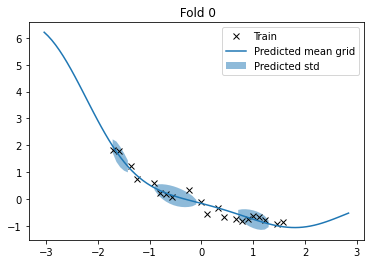

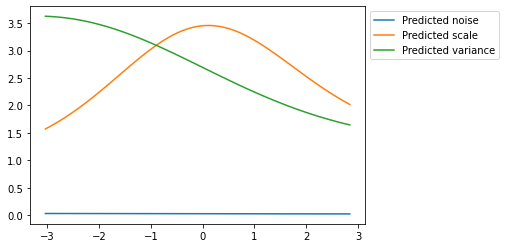

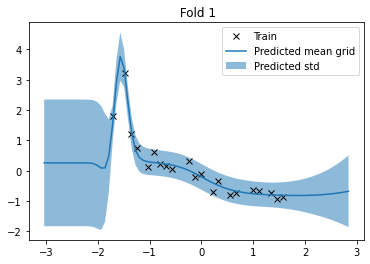

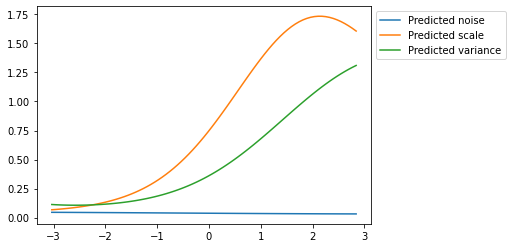

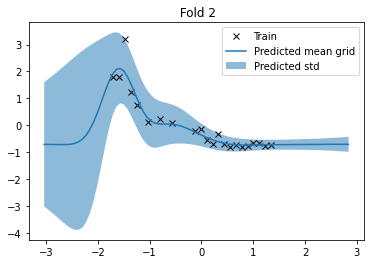

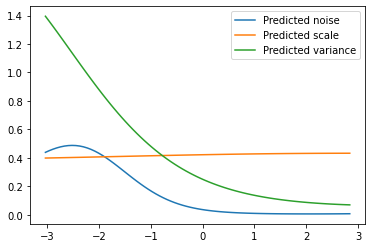

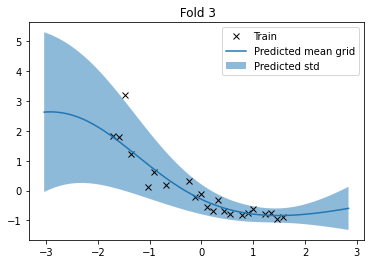

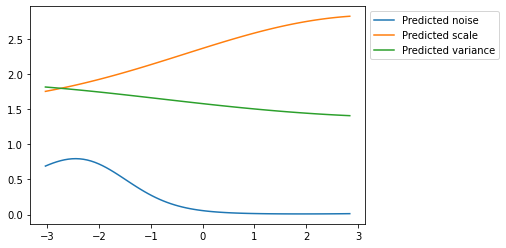

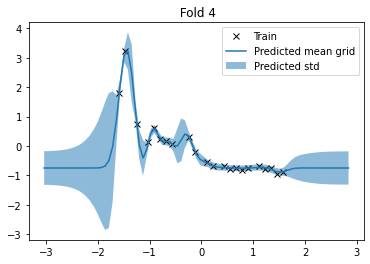

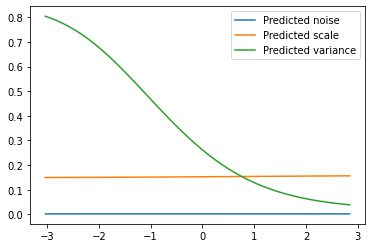

In [76]:
for fold_i in range(data["n_folds"]):
    plt.figure()
    params = result[fold_i]["best_params"]
    plt.plot(
        data["folds"][fold_i]["X_train"],
        data["folds"][fold_i]["y_train"],
        "x",
        label="Train",
        color="k",
    )
#     plt.scatter(
#         data["folds"][fold_i]["X_test"],
#         result[fold_i]["pred_mean"],
#         label="Predicted mean",
#     )
#     plt.scatter(
#         data["folds"][fold_i]["X_test"], data["folds"][fold_i]["y_test"], label="Test"
#     )
    plt.plot(
        data["X_grid"], result[fold_i]["pred_mean_grid"], label="Predicted mean grid"
    )
    plt.fill_between(
        data["X_grid"].ravel(),
        result[fold_i]["pred_mean_grid"].ravel()
        - 2 * jnp.diag(result[fold_i]["pred_covar_grid"]).ravel() ** 0.5,
        result[fold_i]["pred_mean_grid"].ravel()
        + 2 * jnp.diag(result[fold_i]["pred_covar_grid"]).ravel() ** 0.5,
        alpha=0.5,
        label="Predicted std",
    )
#     plt.vlines(params["kernel"]["X_inducing"], -2, 2, label="Inducing points", color="k", alpha=0.2)
    plt.title(" Fold " + str(fold_i))
    plt.legend(bbox_to_anchor=(1, 1))
#     plt.ylim(-4, 4)
    #     plt.savefig(save_name + "_fold_" + str(fold_i) + ".png")
    plt.figure()
    plt.plot(data["X_grid"].ravel(), result[fold_i]["pred_noise"].ravel(), label="Predicted noise")
    plt.plot(data["X_grid"].ravel(), result[fold_i]["pred_scale"].ravel(), label="Predicted scale")
    plt.plot(data["X_grid"].ravel(), result[fold_i]["pred_var"].ravel(), label="Predicted variance")
    plt.legend(bbox_to_anchor=(1, 1))
#     plt.savefig(save_name + "_fold_" + str(fold_i) + "_noise.png")